In [1]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\PREDATOR\Music\ML_project\nlp\nlp-assignment-a3\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [3]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [4]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

In [5]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [6]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [7]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [8]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map: 100%|██████████| 9832/9832 [00:00<00:00, 11629.88 examples/s]


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [9]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [10]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [11]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [12]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

In [13]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(100000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [15]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [16]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 71]), torch.Size([32, 71]))

In [17]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [18]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig, BertForSequenceClassification
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()

- 1  top K layers {1,2,3,4,5,6} from 12-layers teacher to 6-layers student.

In [19]:
# Create a 6-layer student model with the same configuration
student_config1 = BertConfig.from_dict(teacher_model.config.to_dict())
student_config1.num_hidden_layers = 6
student_model1 = BertForSequenceClassification(config=student_config1)  # Assuming it's a classification task

# Copy weights from teacher to student for the first 6 layers
for i in range(6):
    student_model1.bert.encoder.layer[i].load_state_dict(teacher_model.bert.encoder.layer[i].state_dict())


- 2  Bottom K layers {7,8,9,10,11,12} from 12-layers teacher to 6-layers student.

In [20]:
# Create a 6-layer student model with the same configuration
student_config2 = BertConfig.from_dict(teacher_model.config.to_dict())
student_config2.num_hidden_layers = 6
student_model2 = BertForSequenceClassification(config=student_config2)  # Assuming it's a classification task

# Copy weights from teacher to student for the first 6 layers
for i in range(6, 12):
    student_model2.bert.encoder.layer[i-6].load_state_dict(teacher_model.bert.encoder.layer[i].state_dict())

3. Initialize the odd layers {1,3,5,7,8,9,11} from 12-layers teacher to 6-layers student.

In [21]:
student_config3 = BertConfig.from_dict(teacher_model.config.to_dict())
student_config3.num_hidden_layers = 6
student_model3 = BertForSequenceClassification(config=student_config3) 

# Copy weights from teacher to student for the odd layers
for i in [1, 3, 5, 8, 9, 11]:
    student_model3.bert.encoder.layer[(i - 1) // 2].load_state_dict(teacher_model.bert.encoder.layer[i].state_dict())

Initialize even layers student

In [22]:
# Create a 6-layer student model with the same configuration
student_config4 = BertConfig.from_dict(teacher_model.config.to_dict())
student_config4.num_hidden_layers = 6
student_model4 = BertForSequenceClassification(config=student_config4)  

# Copy weights from teacher to student for the even layers
for i in [0, 2, 4, 6, 8, 10]:
    student_model4.bert.encoder.layer[(i - 1) // 2].load_state_dict(teacher_model.bert.encoder.layer[i].state_dict())

In [25]:
student_models_dict = {
    "Top K layers":student_model1,
    "Bottom K layers":student_model2,
    "Odd layers":student_model3,
    "Even Layers":student_model4
}

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
for model_name,model in student_models_dict.items():
    print(f'Student parameters- {model_name}:', count_parameters(model))
    print(count_parameters(model)/count_parameters(teacher_model) * 100)


Teacher parameters : 109484547
Student parameters- Top K layers: 66957315
61.15686353435797
Student parameters- Bottom K layers: 66957315
61.15686353435797
Student parameters- Odd layers: 66957315
61.15686353435797
Student parameters- Even Layers: 66957315
61.15686353435797


In [34]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [35]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

In [36]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [37]:
student_model1 = student_model1.to(device)
student_model2 = student_model2.to(device)
student_model3 = student_model3.to(device)
student_model4 = student_model4.to(device)
teacher_model = teacher_model.to(device)

In [38]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [39]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

#### Train

In [41]:
# Variable to store the model results
models_results = {}

##### Function to train the teacher student model with Distill Bert

In [44]:
import torch
from tqdm.auto import tqdm

def train(model):
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    eval_accuracy = eval_metrics/num_epochs
    print('Avg Metric', eval_metrics/num_epochs)
    return train_losses, eval_losses, eval_accuracy

### Top 6 layers

In [45]:
top_k_train_loss, top_k_eval_loss, top_k_eval_acc = train(student_models_dict["Top K layers"])
models_results["Top K layers"] = {"training_loss":top_k_train_loss, 'validation_loss':top_k_eval_loss, 'validation_accuracy':top_k_eval_acc}

Epoch at 1: Train loss 0.3601:
  - Loss_cls: 1.0099
  - Loss_div: 0.0312
  - Loss_cos: 0.0394
Epoch at 1: Test Acc 0.5520


Epoch at 2: Train loss 0.3424:
  - Loss_cls: 0.9305
  - Loss_div: 0.0572
  - Loss_cos: 0.0397
Epoch at 2: Test Acc 0.5700


Epoch at 3: Train loss 0.3237:
  - Loss_cls: 0.8471
  - Loss_div: 0.0842
  - Loss_cos: 0.0398
Epoch at 3: Test Acc 0.5690


Epoch at 4: Train loss 0.3055:
  - Loss_cls: 0.7667
  - Loss_div: 0.1100
  - Loss_cos: 0.0399
Epoch at 4: Test Acc 0.5540


Epoch at 5: Train loss 0.2935:
  - Loss_cls: 0.7141
  - Loss_div: 0.1265
  - Loss_cos: 0.0400


100%|██████████| 15625/15625 [4:42:46<00:00,  1.09s/it]

Epoch at 5: Test Acc 0.5550
Avg Metric 0.56


### Bottom 6 layers

In [46]:
progress_bar = tqdm(range(num_training_steps))
bot_k_train_loss, bot_k_eval_loss, bot_k_eval_acc = train(student_models_dict["Bottom K layers"])
models_results["Bottom K layers"] = {"training_loss":bot_k_train_loss, 'validation_loss':bot_k_eval_loss, 'validation_accuracy':bot_k_eval_acc}

 20%|██        | 3125/15625 [1:07:42<4:18:49,  1.24s/it]

Epoch at 1: Train loss 0.6596:
  - Loss_cls: 1.1111
  - Loss_div: 0.0112
  - Loss_cos: 0.8565
Epoch at 1: Test Acc 0.3330


 40%|████      | 6250/15625 [2:13:36<5:25:32,  2.08s/it] 

Epoch at 2: Train loss 0.6594:
  - Loss_cls: 1.1114
  - Loss_div: 0.0112
  - Loss_cos: 0.8555
Epoch at 2: Test Acc 0.3330


 60%|██████    | 9375/15625 [2:49:06<49:32,  2.10it/s]   

Epoch at 3: Train loss 0.6591:
  - Loss_cls: 1.1112
  - Loss_div: 0.0112
  - Loss_cos: 0.8550
Epoch at 3: Test Acc 0.3330


 80%|████████  | 12500/15625 [3:22:36<23:42,  2.20it/s]  

Epoch at 4: Train loss 0.6592:
  - Loss_cls: 1.1113
  - Loss_div: 0.0112
  - Loss_cos: 0.8552
Epoch at 4: Test Acc 0.3330


100%|██████████| 15625/15625 [3:47:41<00:00,  2.03it/s]  

Epoch at 5: Train loss 0.6594:
  - Loss_cls: 1.1112
  - Loss_div: 0.0112
  - Loss_cos: 0.8559


100%|██████████| 15625/15625 [3:47:45<00:00,  1.14it/s]

Epoch at 5: Test Acc 0.3330
Avg Metric 0.333


### Odd Layers

In [48]:
progress_bar = tqdm(range(num_training_steps))
odd_train_loss, odd_eval_loss, odd_eval_acc = train(student_models_dict["Odd layers"])
models_results["Odd layers"] = {"training_loss":odd_train_loss, 'validation_loss':odd_eval_loss, 'validation_accuracy':odd_eval_acc}

  0%|          | 0/15625 [3:48:21<?, ?it/s]


Epoch at 1: Train loss 0.8125:
  - Loss_cls: 1.1065
  - Loss_div: 0.0113
  - Loss_cos: 1.3195
Epoch at 1: Test Acc 0.3230


Epoch at 2: Train loss 0.8130:
  - Loss_cls: 1.1060
  - Loss_div: 0.0113
  - Loss_cos: 1.3216
Epoch at 2: Test Acc 0.3230


Epoch at 3: Train loss 0.8125:
  - Loss_cls: 1.1064
  - Loss_div: 0.0113
  - Loss_cos: 1.3199
Epoch at 3: Test Acc 0.3230


Epoch at 4: Train loss 0.8119:
  - Loss_cls: 1.1065
  - Loss_div: 0.0113
  - Loss_cos: 1.3180
Epoch at 4: Test Acc 0.3230


Epoch at 5: Train loss 0.8120:
  - Loss_cls: 1.1059
  - Loss_div: 0.0113
  - Loss_cos: 1.3188


100%|██████████| 15625/15625 [2:14:18<00:00,  1.94it/s]

Epoch at 5: Test Acc 0.3230
Avg Metric 0.323


### Even Layers

In [49]:
progress_bar = tqdm(range(num_training_steps))
even_train_loss, even_eval_loss, even_eval_acc = train(student_models_dict["Even Layers"])
models_results["Even Layers"] = {"training_loss":even_train_loss, 'validation_loss':even_eval_loss, 'validation_accuracy':even_eval_acc}

 20%|██        | 3125/15625 [22:33<1:23:50,  2.48it/s]

Epoch at 1: Train loss 0.5076:
  - Loss_cls: 1.1089
  - Loss_div: 0.0056
  - Loss_cos: 0.4084
Epoch at 1: Test Acc 0.3260


 40%|████      | 6250/15625 [45:01<1:13:53,  2.11it/s]

Epoch at 2: Train loss 0.5072:
  - Loss_cls: 1.1087
  - Loss_div: 0.0055
  - Loss_cos: 0.4073
Epoch at 2: Test Acc 0.3260


 60%|██████    | 9375/15625 [1:07:31<39:56,  2.61it/s]  

Epoch at 3: Train loss 0.5082:
  - Loss_cls: 1.1090
  - Loss_div: 0.0056
  - Loss_cos: 0.4101
Epoch at 3: Test Acc 0.3260


 80%|████████  | 12500/15625 [1:29:57<19:52,  2.62it/s] 

Epoch at 4: Train loss 0.5079:
  - Loss_cls: 1.1088
  - Loss_div: 0.0056
  - Loss_cos: 0.4094
Epoch at 4: Test Acc 0.3260


100%|██████████| 15625/15625 [1:52:29<00:00,  2.59it/s]  

Epoch at 5: Train loss 0.5080:
  - Loss_cls: 1.1094
  - Loss_div: 0.0056
  - Loss_cos: 0.4091


100%|██████████| 15625/15625 [1:52:32<00:00,  2.31it/s]

Epoch at 5: Test Acc 0.3260
Avg Metric 0.326


In [50]:
models_results

{'Top K layers': {'training_loss': [0.36014952415466306,
   0.3424459785556793,
   0.32367087875366213,
   0.3055267945051193,
   0.29352552999973297],
  'validation_loss': [0.9815551359206438,
   0.9543159883469343,
   0.9524641521275043,
   0.960652181878686,
   0.9672658313065767],
  'validation_accuracy': 0.56},
 'Bottom K layers': {'training_loss': [0.6595862005233765,
   0.659375339012146,
   0.6591428788566589,
   0.6592319050216675,
   0.6594223204803467],
  'validation_loss': [1.1041773781180382,
   1.1041773781180382,
   1.1041773781180382,
   1.1041773781180382,
   1.1041773781180382],
  'validation_accuracy': 0.333},
 'Odd layers': {'training_loss': [0.812468858013153,
   0.8129541181945801,
   0.81254706325531,
   0.8119436407661438,
   0.8120028093147278],
  'validation_loss': [1.1043631471693516,
   1.1043631471693516,
   1.1043631471693516,
   1.1043631471693516,
   1.1043631471693516],
  'validation_accuracy': 0.323},
 'Even Layers': {'training_loss': [0.50761022520065

In [51]:
final_results = {}
for k,v in models_results.items():
    final_results[k] = {"training_loss":sum(v['training_loss'])/len(v['training_loss']), "validation_loss":sum(v['validation_loss'])/len(v['validation_loss']), "validation_accuracy":v['validation_accuracy']}
    

In [54]:
final_results

{'Top K layers': {'training_loss': 0.3250637411937714,
  'validation_loss': 0.963250657916069,
  'validation_accuracy': 0.56},
 'Bottom K layers': {'training_loss': 0.6593517287788391,
  'validation_loss': 1.1041773781180382,
  'validation_accuracy': 0.333},
 'Odd layers': {'training_loss': 0.8123832979087829,
  'validation_loss': 1.1043631471693516,
  'validation_accuracy': 0.323},
 'Even Layers': {'training_loss': 0.5077977884311675,
  'validation_loss': 1.1099427454173565,
  'validation_accuracy': 0.326}}

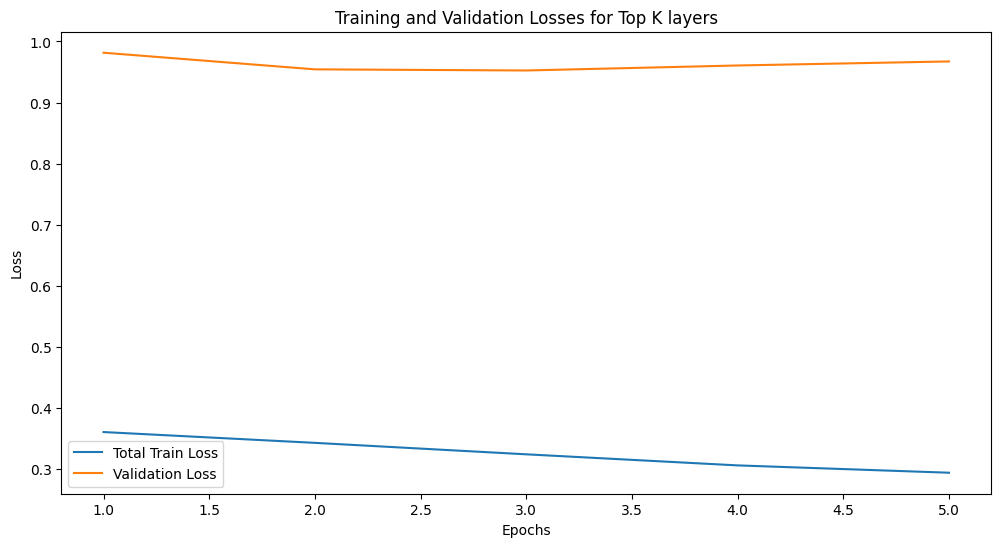

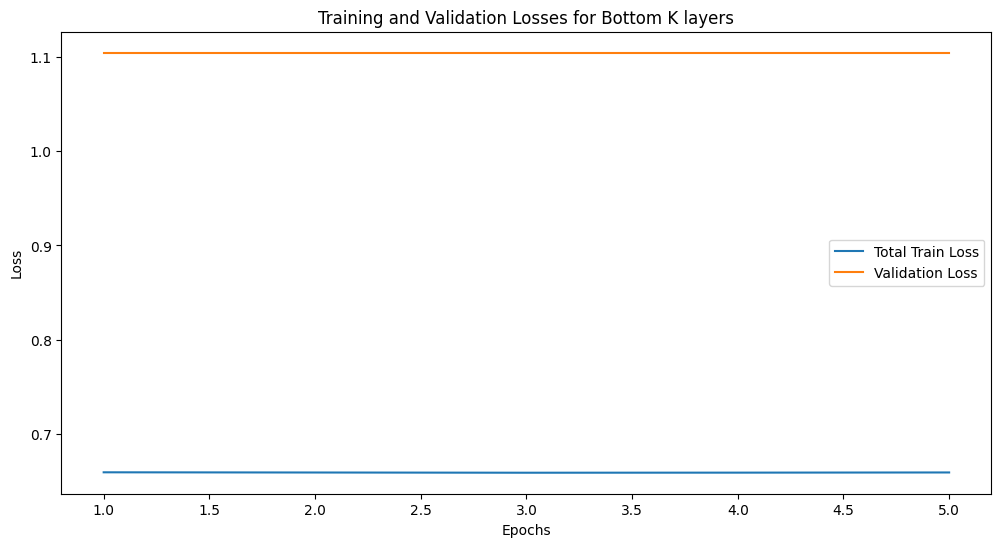

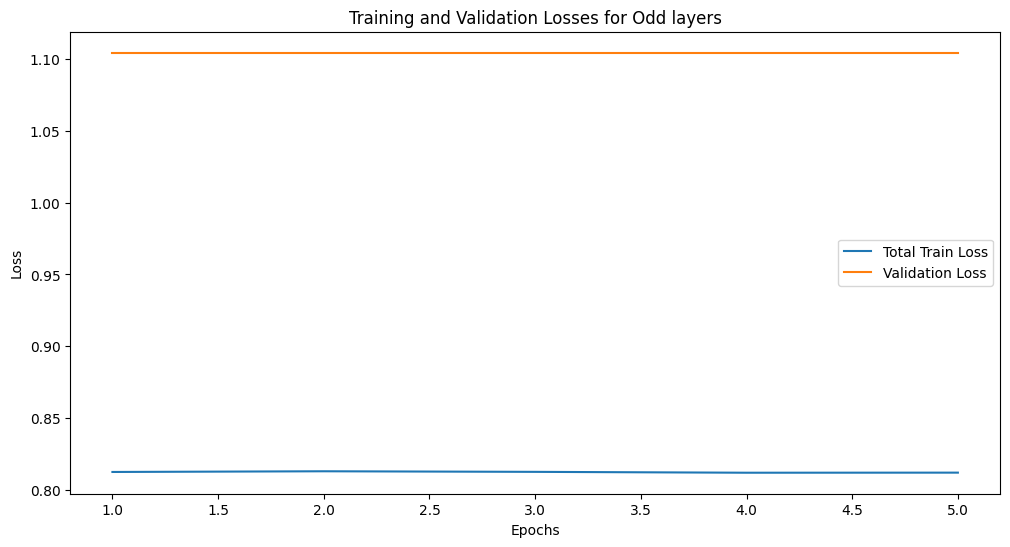

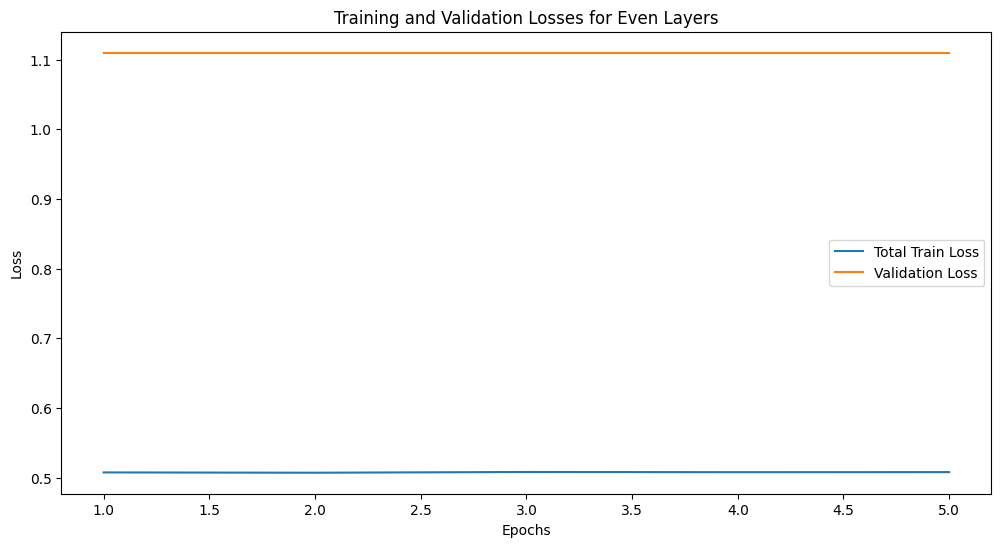

In [55]:
import matplotlib.pyplot as plt
# Plotting

for k,v in models_results.items():
    epochs_list = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, v['training_loss'], label='Total Train Loss')
    # plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    # plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    # plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, v['validation_loss'], label='Validation Loss')

    plt.title(f'Training and Validation Losses for {k}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [66]:
import pandas as pd
model_results_df = pd.DataFrame(final_results)

In [67]:
model_results = model_results_df.T

In [61]:
print (model_results.index.name)


None


In [68]:
model_results.index.name = 'Student Layer'

In [69]:
model_results.head()

,training_loss,validation_loss,validation_accuracy
Student Layer,,,
Top K layers,0.325064,0.963251,0.560
Bottom K layers,0.659352,1.104177,0.333
Odd layers,0.812383,1.104363,0.323
Even Layers,0.507798,1.109943,0.326
